# IonBeam API Quickstart

The api is currently hosted as http://ionbeam-ichange.ecmwf-ichange.f.ewcloud.host/api/v1/

See http://ionbeam-ichange.ecmwf-ichange.f.ewcloud.host/docs for the API docs. There are 4 endpoints:

- **/health:** Just returns 200 if the API is up.
- **/stations:** Used to query the metadata about stations producing data and meteotracker tracks.
- **/list:** Used to quickly list what data granules exist.
- **/retrieve:** Used to download data granules.

## Stations

The `/stations` endpoint returns a list of station objects, [optional filters can and should be applied](http://ionbeam-ichange.ecmwf-ichange.f.ewcloud.host/docs#/default/get_stations_api_v1_stations_get) to keep the size of the response manageable.

Station objects follow this structure:

```
{'name': 'Trebiano',
 'description': None,
 'platform': 'acronet',
 'external_id': 'trebiano',
 'internal_id': 'b364930470debbb5',
 'aggegation_type': 'by_time',
 'location': {'lat': 44.10177, 'lon': 9.925187},
 'time_span': {'start': '2024-09-07T16:00:00+00:00',
  'end': '2025-01-21T16:22:00+00:00'},
 'authors': [{'id': 436, 'name': 'acronet'}],
 'mars_selection': {'class': 'rd',
  'expver': 'xxxx',
  'stream': 'lwda',
  'aggregation_type': 'by_time',
  'platform': 'acronet',
  'station_id': 'b364930470debbb5',
  'date': '20240907/to/20250121/by/1'}}
```

## Retrieve

The `mars_selection` attribute of a station gives an example MARS selection that would retrieve all the data for this station when passed to the [`/retrieve` endpoint](http://ionbeam-ichange.ecmwf-ichange.f.ewcloud.host/docs#/default/fdb_retrieve_api_v1_retrieve_get) as query parameters. 

`/retrieve` takes an optional `format` key that may be `json`, `csv`, `parquet`. `parquet` is likely to be the most performant.

You may also omit the `station_id` key from the MARS selection to retrieve all data for a platform.

You may omit the `platform` key too to retrieve all data for a givem time period. 

Currently, `/retrieve` requests that match with more than 200 data granules will get a 403, this is to avoid DOS's the api server accidentally by sending an empty request.

`/list` takes the same arguments as `/retrieve` (except for `format`) and serves as a way to determine what granules exist before downloading them.

In [ ]:
# !pip install pandas geopandas

In [150]:
import requests
from datetime import datetime, timedelta, UTC
import pandas as pd
from io import BytesIO
import json
from collections import defaultdict

session = requests.Session()
url = "http://ionbeam-ichange.ecmwf-ichange.f.ewcloud.host/api/v1/"

class API_Error(Exception):
    pass

def api_get(path, *args, **kwargs):
    r = session.get(url + path, stream=True, *args, **kwargs)
    if not r.ok:
        raise API_Error(json.dumps(r.json(), indent = 4))
    return r

api_get("health").json()

{'status': 'API is up and running'}

In [151]:
def sort_by_platform(stations) -> dict[str, list[dict]]:
    by_platform = defaultdict(list)
    for s in stations:
        by_platform[s["platform"]].append(s)
    return by_platform
    
lookback = timedelta(hours = 54) 

recent_stations = api_get("stations", params = {
    "start_time" : datetime.now(UTC) - lookback
}).json()

by_platform = sort_by_platform(recent_stations)

print(f"Stations with data in the last: ({lookback})")
print({k : len(v) for k, v in sort_by_platform(recent_stations).items()})
print()

Stations with data in the last: (2 days, 6:00:00)
{'acronet': 99, 'smart_citizen_kit': 4, 'meteotracker': 12}



In [152]:
df = None
now = datetime.now(UTC)
if by_platform["acronet"]:
    example_station = by_platform["acronet"][0]
    print(json.dumps(example_station, indent = 4))
    args = {
        "start_time" : (now - timedelta(hours =  150)).isoformat(),
        "end_time": now.isoformat(),
    }
    
    data = api_get("retrieve", params = example_station["mars_selection"] | args | dict(format = "parquet"))
    df = pd.read_parquet(BytesIO(data.content))
df

{
    "name": "Sede Comunale Moconesi",
    "description": null,
    "platform": "acronet",
    "external_id": "sede_comunale_moconesi",
    "internal_id": "636e5a409d8ca7d7",
    "aggegation_type": "by_time",
    "location": {
        "lat": 44.41948,
        "lon": 9.212386
    },
    "time_span": {
        "start": "2022-04-29T12:00:00+00:00",
        "end": "2025-01-23T14:22:00+00:00"
    },
    "authors": [
        {
            "id": 436,
            "name": "acronet"
        }
    ],
    "mars_selection": {
        "class": "rd",
        "expver": "xxxx",
        "stream": "lwda",
        "aggregation_type": "by_time",
        "platform": "acronet",
        "station_id": "636e5a409d8ca7d7",
        "date": "20220429/to/20250123/by/1"
    }
}


,platform,author,station_id,external_station_id,station_name,aggregation_type,chunk_date,chunk_time,lat,lon,...,wind_direction_near_surface,battery_level,air_pressure_near_surface,air_temperature_near_surface,wind_gust,relative_humidity_near_surface,wind_speed_near_surface,solar_radiation,thermometer_max,thermometer_min
datetime,,,,,,,,,,,,,,,,,,,,,
2025-01-17 11:00:00+00:00,acronet,acronet,636e5a409d8ca7d7,sede_comunale_moconesi,Sede Comunale Moconesi,by_time,20250117,1100,44.41948,9.212386,...,242.70000,13.480000,1017.56000,11.000000,4.1,40.4,3.0,NaN,NaN,NaN
2025-01-17 11:01:00+00:00,acronet,acronet,636e5a409d8ca7d7,sede_comunale_moconesi,Sede Comunale Moconesi,by_time,20250117,1100,44.41948,9.212386,...,164.20000,13.480000,1017.69995,11.300000,2.1,39.8,1.4,NaN,NaN,NaN
2025-01-17 11:02:00+00:00,acronet,acronet,636e5a409d8ca7d7,sede_comunale_moconesi,Sede Comunale Moconesi,by_time,20250117,1100,44.41948,9.212386,...,171.90001,13.490000,1017.68000,11.100000,3.6,39.4,2.2,NaN,NaN,NaN
2025-01-17 11:03:00+00:00,acronet,acronet,636e5a409d8ca7d7,sede_comunale_moconesi,Sede Comunale Moconesi,by_time,20250117,1100,44.41948,9.212386,...,236.70000,13.500000,1017.56000,10.900001,2.9,38.8,1.8,NaN,NaN,NaN
2025-01-17 11:04:00+00:00,acronet,acronet,636e5a409d8ca7d7,sede_comunale_moconesi,Sede Comunale Moconesi,by_time,20250117,1100,44.41948,9.212386,...,263.60000,13.490000,1017.50000,10.900001,3.3,38.9,2.1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-23 14:18:00+00:00,acronet,acronet,636e5a409d8ca7d7,sede_comunale_moconesi,Sede Comunale Moconesi,by_time,20250123,1400,44.41948,9.212386,...,299.90000,12.300000,996.02997,12.100000,0.6,98.4,0.3,NaN,NaN,NaN
2025-01-23 14:19:00+00:00,acronet,acronet,636e5a409d8ca7d7,sede_comunale_moconesi,Sede Comunale Moconesi,by_time,20250123,1400,44.41948,9.212386,...,279.00000,12.300000,996.05000,12.100000,0.9,98.3,0.6,NaN,NaN,NaN
2025-01-23 14:20:00+00:00,acronet,acronet,636e5a409d8ca7d7,sede_comunale_moconesi,Sede Comunale Moconesi,by_time,20250123,1400,44.41948,9.212386,...,256.50000,12.300000,996.02997,12.100000,0.8,98.3,0.7,NaN,NaN,NaN


{'name': 'Rifugio Argentea', 'description': None, 'platform': 'acronet', 'external_id': 'rifugio_argentea', 'internal_id': 'cbf531dac07bddb4', 'aggegation_type': 'by_time', 'location': {'lat': 44.43832, 'lon': 8.641541}, 'time_span': {'start': '2022-04-29T12:00:00+00:00', 'end': '2025-01-23T14:22:00+00:00'}, 'authors': [{'id': 436, 'name': 'acronet'}], 'mars_selection': {'class': 'rd', 'expver': 'xxxx', 'stream': 'lwda', 'aggregation_type': 'by_time', 'platform': 'acronet', 'station_id': 'cbf531dac07bddb4', 'date': '20220429/to/20250123/by/1'}}
Latest data: 2025-01-23 14:22:00+00:00


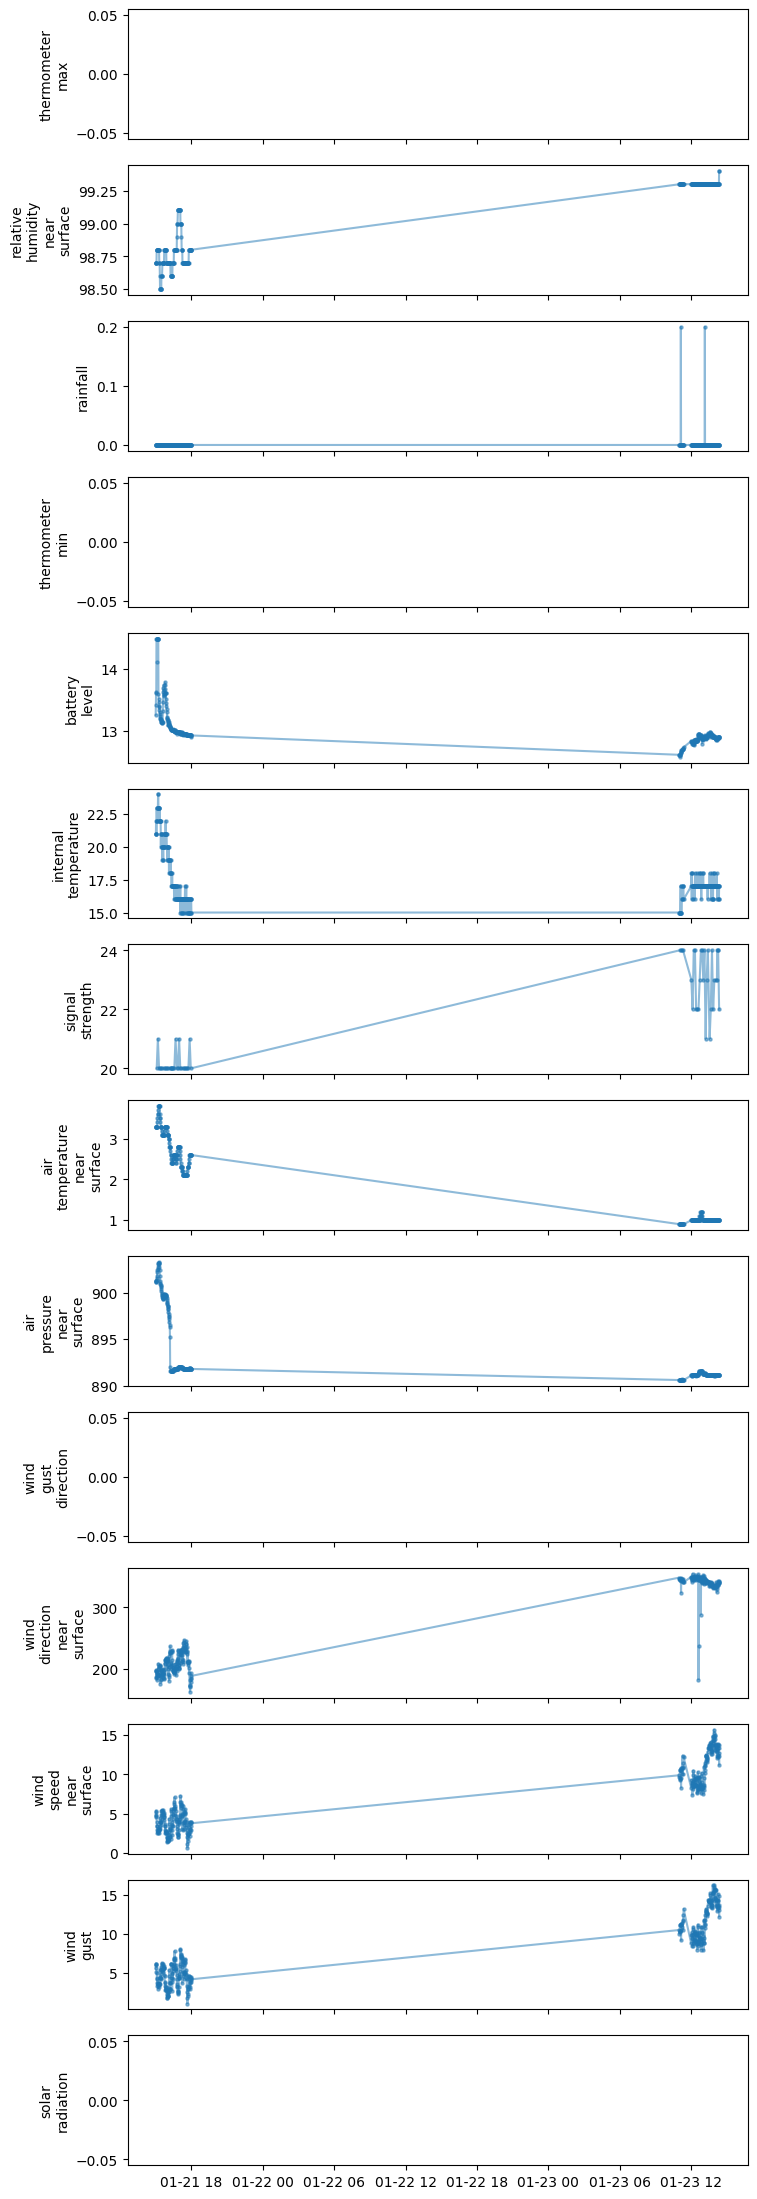

In [153]:
from matplotlib import pyplot as plt

def plot_example_station(example_station):
    latest = datetime.fromisoformat(example_station["time_span"]["end"])
    print(f"Latest data: {latest}")
    args = {
        "start_time" : (latest - timedelta(hours = 48)).isoformat(),
        "end_time": latest.isoformat(),
        "format": "parquet"
    }
    
    data = api_get("retrieve", params = example_station["mars_selection"] | args)
    df = pd.read_parquet(BytesIO(data.content))
    
    exclude_columns = {"external_id", "date", "lat", "lon", "altitude", "chunk_date", "chunk_time"}
    numeric_columns = [col for col, dtype in zip(df.columns, df.dtypes) 
                       if (dtype == "float64" or dtype == "int64")
                       and col not in exclude_columns]

    fig, axes = plt.subplots(len(numeric_columns), 1, figsize=(8, 2*len(numeric_columns)), squeeze = True, sharex=True)

    for ax, col in zip(axes, numeric_columns):
        ax.set(ylabel = col.replace("_", "\n"))
        ax.scatter(df.index, df[col], 5, alpha = 0.5)

        not_nan = ~df[col].isnull()
        ax.plot(df.index[not_nan], df[col][not_nan], alpha = 0.5)
        #ax.plot(df.index, df[col].rolling(window=20).mean(), label = "rolling mean", alpha = 0.5)
    
if by_platform["acronet"]:
    example_station = by_platform["acronet"][-1]
    print(example_station)
    plot_example_station(example_station)

{'name': 'I-CHANGE CIMA CASTAGNA', 'description': None, 'platform': 'smart_citizen_kit', 'external_id': '16643', 'internal_id': '3dd2fa657adaf3d7', 'aggegation_type': 'by_time', 'location': {'lat': 44.49617, 'lon': 8.92065}, 'time_span': {'start': '2025-01-03T15:16:43+00:00', 'end': '2025-01-23T16:27:14+00:00'}, 'authors': [{'id': 16, 'name': 'smart_citizen_kit'}], 'mars_selection': {'class': 'rd', 'expver': 'xxxx', 'stream': 'lwda', 'aggregation_type': 'by_time', 'platform': 'smart_citizen_kit', 'station_id': '3dd2fa657adaf3d7', 'date': '20250103/to/20250123/by/1'}}
Latest data: 2025-01-23 16:27:14+00:00


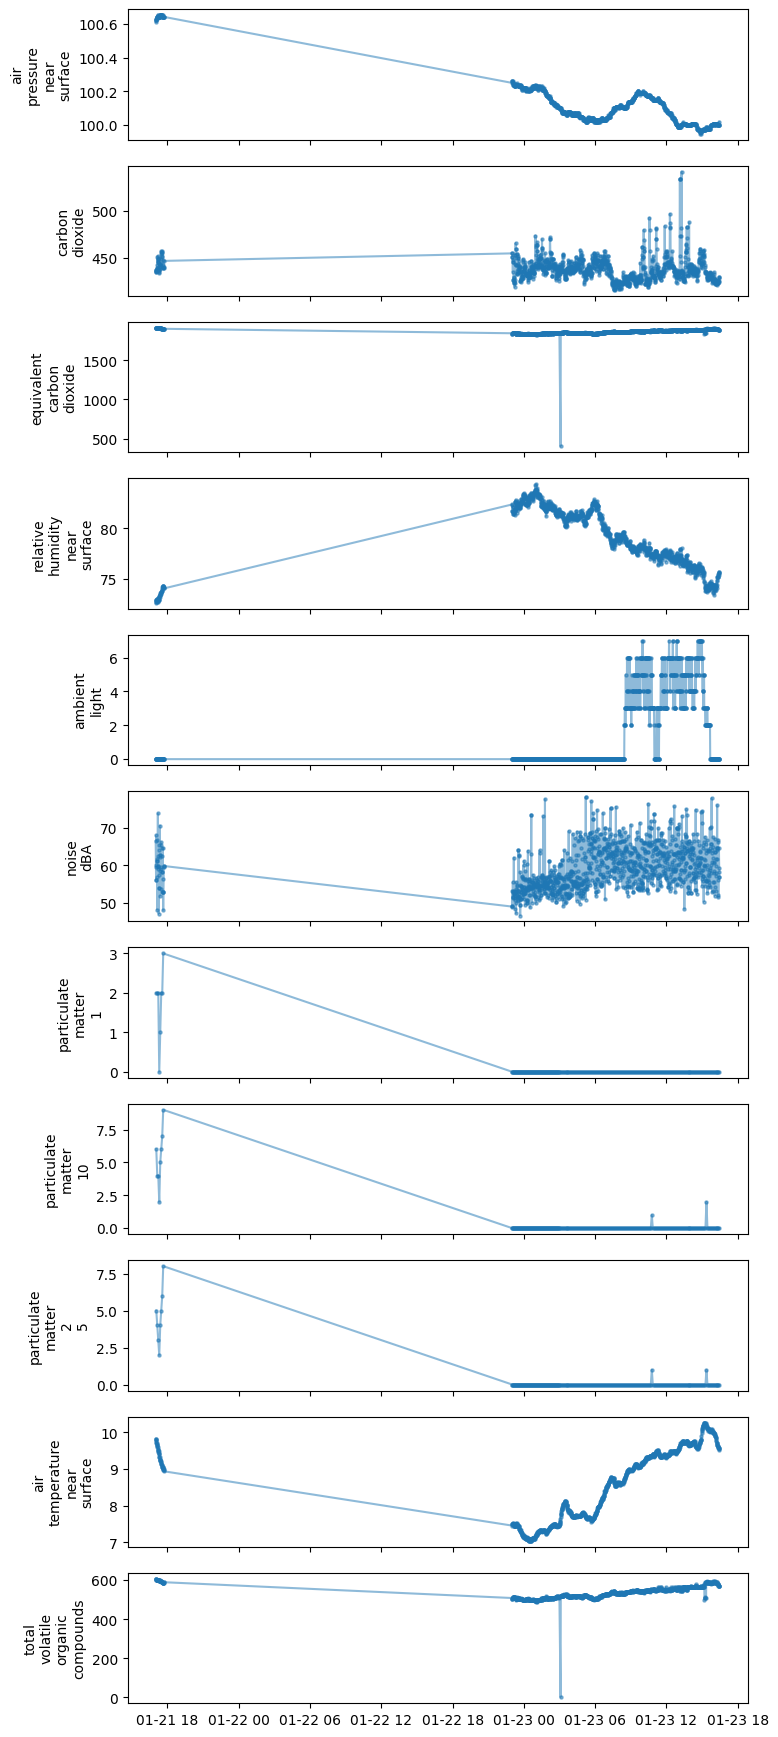

In [154]:
if by_platform["smart_citizen_kit"]:
    example_station = by_platform["smart_citizen_kit"][-1]
    print(example_station)
    plot_example_station(example_station)

## Retrieve and plot a Meteotracker track

In [155]:
example_station = by_platform["meteotracker"][-1]
print("track time span", example_station["time_span"])

print(json.dumps(example_station["mars_selection"], indent = 4))
granule_list = api_get("list", params = example_station["mars_selection"]).json()

print(f"The above MARS request matches {len(granule_list)} data granule(s).")

args = {
    "format" : "parquet"
}

track time span {'start': '2025-01-21T16:07:01.315000+00:00', 'end': '2025-01-21T16:24:54.415000+00:00'}
{
    "class": "rd",
    "expver": "xxxx",
    "stream": "lwda",
    "aggregation_type": "by_time",
    "platform": "meteotracker",
    "station_id": "a8ab962b8ae1192a",
    "date": "20250121",
    "time": "1600"
}
The above MARS request matches 1 data granule(s).


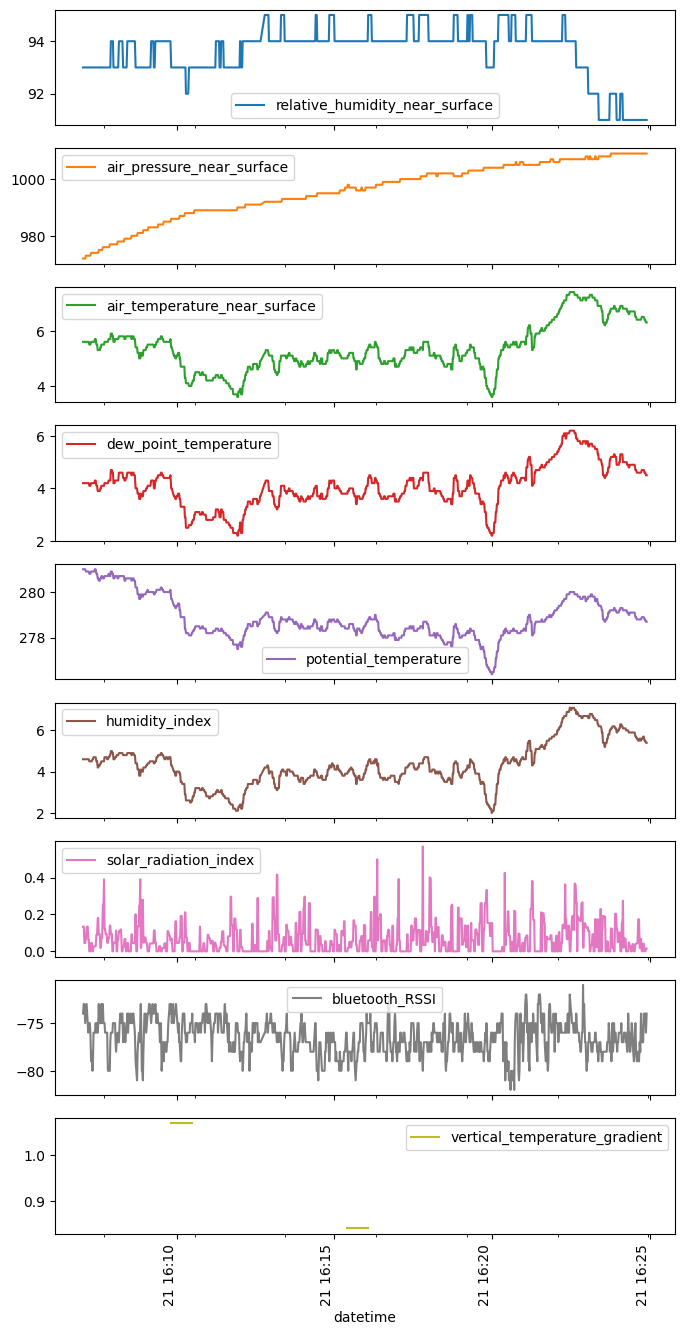

In [156]:
data = api_get("retrieve", params = example_station["mars_selection"] | args)
df = pd.read_parquet(BytesIO(data.content))

exclude_columns = {"external_id", "date", "lat", "lon", "altitude"}
numeric_columns = [col for col, dtype in zip(df.columns, df.dtypes) 
                   if (dtype == "float64" or dtype == "int64")
                   and col not in exclude_columns]

axes = df.plot(
    y = numeric_columns,
    subplots=True, layout=(len(numeric_columns), 1), figsize=(8, 2*len(numeric_columns)), sharex=True, rot=90)


In [157]:
import geopandas as gpd
geo_df = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat), crs=4326)
geo_df.explore(column = "altitude")

## Retrieve ALL data for ALL platforms in the last few hours:

In [158]:
data = api_get("retrieve", params = dict(
    # platform = "acronet",
    start_time = datetime.now(UTC) - timedelta(hours = 10),
    end_time = datetime.now(UTC),
    format = "parquet"
))
df = pd.read_parquet(BytesIO(data.content))
df

,platform,author,station_id,external_station_id,station_name,aggregation_type,chunk_date,chunk_time,lat,lon,...,wind_direction_near_surface,internal_temperature,signal_strength,rainfall,wind_gust,wind_gust_direction,wind_speed_near_surface,thermometer_min,thermometer_max,solar_radiation
datetime,,,,,,,,,,,,,,,,,,,,,
2025-01-23 07:00:17+00:00,smart_citizen_kit,smart_citizen_kit,1862bf241307774f,16030,I-CHANGE CIMA SAVONA,by_time,20250123,0700,44.29920,8.45138,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-23 07:00:19+00:00,smart_citizen_kit,smart_citizen_kit,b93bfbb97112ae04,16517,I-CHANGE CIMA ARENZANO,by_time,20250123,0700,44.39930,8.67264,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-23 07:00:42+00:00,smart_citizen_kit,smart_citizen_kit,af4fb2ebc14b6ae6,16774,I-CHANGE CHIAVARI,by_time,20250123,0700,44.32045,9.32365,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-23 07:00:43+00:00,smart_citizen_kit,smart_citizen_kit,3dd2fa657adaf3d7,16643,I-CHANGE CIMA CASTAGNA,by_time,20250123,0700,44.49617,8.92065,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-23 07:01:17+00:00,smart_citizen_kit,smart_citizen_kit,1862bf241307774f,16030,I-CHANGE CIMA SAVONA,by_time,20250123,0700,44.29920,8.45138,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-23 16:26:23+00:00,smart_citizen_kit,smart_citizen_kit,af4fb2ebc14b6ae6,16774,I-CHANGE CHIAVARI,by_time,20250123,1600,44.32045,9.32365,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-23 16:27:14+00:00,smart_citizen_kit,smart_citizen_kit,1862bf241307774f,16030,I-CHANGE CIMA SAVONA,by_time,20250123,1600,44.29920,8.45138,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-23 16:27:14+00:00,smart_citizen_kit,smart_citizen_kit,3dd2fa657adaf3d7,16643,I-CHANGE CIMA CASTAGNA,by_time,20250123,1600,44.49617,8.92065,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [159]:
import geopandas as gpd

# Just show one point from each station and track
deduped = df.drop_duplicates(subset=["station_id"])
gdf = gpd.GeoDataFrame(
    deduped,
    geometry=gpd.points_from_xy(deduped['lon'], deduped['lat']),
    crs="EPSG:4326"
)
gdf.explore()